# Notebook 02 — Feature Engineering & Signal Design

This notebook turns the raw screener snapshots into a **feature store** for each
(run_date, ticker) pair.

We’ll:

- Pull the last *N* days of screener history from DuckDB.
- Engineer features that capture:
  - move vs recent volatility
  - volatility trend
  - short-term trend & choppiness
  - simple volatility / edge / liquidity regimes
- Save everything back into a `screener_features` table for:
  - Notebook 03 (rule-based backtesting)
  - future RL experiments

This notebook **does not** call Polygon directly. It only works off the cached
DuckDB database to avoid rate limits.

## 0. Notebook parameters

We use the same rolling window idea as Notebook 01 so features are based on the last N days of data.
You can change `LOOKBACK_DAYS` later without touching the SQL.

## 1. Imports and connect to DuckDB

We re-use the same DuckDB database created by the Streamlit screener.

In [1]:
import duckdb
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, timedelta

# Consistent chart size
plt.rcParams["figure.figsize"] = (10, 6)

# ---- Notebook parameters ----
# Keep this aligned with Notebook 01 so both look at the same history window.
LOOKBACK_DAYS = 60  # you can change this to 30, 90, etc.

today = date.today()
cutoff_date = today - timedelta(days=LOOKBACK_DAYS)

print(f"Using last {LOOKBACK_DAYS} days, from {cutoff_date.isoformat()} to {today.isoformat()}")

Using last 60 days, from 2025-10-02 to 2025-12-01


## Connect to the DuckDB screener database

We’ll connect to the same DuckDB file used in Notebook 01 and confirm that the
screener tables are available.

In [2]:
# Path: notebooks/ -> ../data/volatility_alpha.duckdb
DB_PATH = (Path.cwd().parent / "data" / "volatility_alpha.duckdb").as_posix()

# --- Safe reconnect logic ---
# If a DuckDB connection named `con` already exists, close it first.
if "con" in globals():
    try:
        con.close()  # type: ignore
    except Exception:
        pass

# Open a fresh connection
con = duckdb.connect(DB_PATH)

# Sanity check: list tables
con.sql("SHOW TABLES;").df()

,name
0,screener_features
1,screener_returns
2,screener_returns_with_target
3,screener_signals
4,screener_snapshots


## 2. Load recent screener history

We pull the last **LOOKBACK_DAYS** of screener snapshots. Each row represents one
ticker on one run date.

Fields used here:

- `run_date`
- `ticker`
- `last_price`
- `day_pct` (today's % move vs prior close)
- `volume`
- `rv_20d`, `rv_60d` (20/60-day realized volatility, annualized)
- `edge_score` (simple composite of |Day %| and RV20)

We’ll sort by `(ticker, run_date)` so rolling features compute correctly.


In [3]:
query = f"""
SELECT
    run_date,
    ticker,
    last_price,
    day_pct,
    volume,
    rv_20d,
    rv_60d,
    edge_score
FROM screener_snapshots
WHERE run_date >= DATE '{cutoff_date.isoformat()}'
ORDER BY ticker, run_date
"""

df = con.sql(query).df()
df["run_date"] = pd.to_datetime(df["run_date"])

print(df.shape)
df.head()

(10, 8)


,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score
0,2025-11-30,AMD,217.529999,1.535658,18658000.0,68.691670,74.422502,35.113664
1,2025-12-01,AMD,215.660004,-0.859649,3312950.0,68.691670,74.422502,34.775660
2,2025-11-30,NVDA,177.000000,-1.808496,121332800.0,41.973659,38.081710,21.891077
3,2025-12-01,NVDA,176.332199,-0.377289,22401443.0,41.973659,38.081710,21.175474
4,2025-11-30,QQQ,619.250000,0.810715,23034400.0,21.501747,17.302496,11.156231


## 3. Engineer core scalar features

We start with simple, per-day features that don’t require rolling windows:

- **move_vs_rv20**: today’s move relative to 20-day realized vol  
  \> big positive values = unusually large moves
- **rv_trend**: `rv_20d − rv_60d`  
  \> positive = vol picking up, negative = vol calming down

In [4]:
features = df.copy()

# Guard against division by zero
features["move_vs_rv20"] = features["day_pct"] / features["rv_20d"].replace(0, np.nan)

# Volatility trend: short-term vs longer-term realized vol
features["rv_trend"] = features["rv_20d"] - features["rv_60d"]

features.head()

,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score,move_vs_rv20,rv_trend
0,2025-11-30,AMD,217.529999,1.535658,18658000.0,68.691670,74.422502,35.113664,0.022356,-5.730832
1,2025-12-01,AMD,215.660004,-0.859649,3312950.0,68.691670,74.422502,34.775660,-0.012515,-5.730832
2,2025-11-30,NVDA,177.000000,-1.808496,121332800.0,41.973659,38.081710,21.891077,-0.043086,3.891949
3,2025-12-01,NVDA,176.332199,-0.377289,22401443.0,41.973659,38.081710,21.175474,-0.008989,3.891949
4,2025-11-30,QQQ,619.250000,0.810715,23034400.0,21.501747,17.302496,11.156231,0.037705,4.199251


## 4. Add short-term rolling stats (5-day window)

For each ticker we compute:

- **day_pct_ma_5**: 5-day rolling mean of Day % (short-term trend)
- **day_pct_vol_5**: 5-day rolling std of Day % (short-term choppiness)

These are natural candidates for RL state features and for rule-based filters.

In [5]:
## Rolling Window Features

# Sort to be extra safe
features = features.sort_values(["ticker", "run_date"])

group = features.groupby("ticker", group_keys=False)

features["day_pct_ma_5"] = (
    group["day_pct"]
    .rolling(window=5, min_periods=2)
    .mean()
    .reset_index(level=0, drop=True)
)

features["day_pct_vol_5"] = (
    group["day_pct"]
    .rolling(window=5, min_periods=2)
    .std()
    .reset_index(level=0, drop=True)
)

features.head()


,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score,move_vs_rv20,rv_trend,day_pct_ma_5,day_pct_vol_5
0,2025-11-30,AMD,217.529999,1.535658,18658000.0,68.691670,74.422502,35.113664,0.022356,-5.730832,NaN,NaN
1,2025-12-01,AMD,215.660004,-0.859649,3312950.0,68.691670,74.422502,34.775660,-0.012515,-5.730832,0.338004,1.693738
2,2025-11-30,NVDA,177.000000,-1.808496,121332800.0,41.973659,38.081710,21.891077,-0.043086,3.891949,NaN,NaN
3,2025-12-01,NVDA,176.332199,-0.377289,22401443.0,41.973659,38.081710,21.175474,-0.008989,3.891949,-1.092892,1.012016
4,2025-11-30,QQQ,619.250000,0.810715,23034400.0,21.501747,17.302496,11.156231,0.037705,4.199251,NaN,NaN


## 5. Categorise regimes and buckets

We turn continuous values into simple, interpretable buckets:

- **Volatility regime (`vol_regime`)**  
  - `low` / `normal` / `high` based on RV20 quantiles.
- **Edge bucket (`edge_bucket`)**  
  - `quiet` / `active` / `hot` using simple thresholds on `edge_score`.
- **Liquidity bucket (`liquidity_bucket`)**  
  - `thin` / `normal` / `thick` based on volume quantiles.

These categories make it easy to define rules like:

> “Trade only high-vol names with *hot* edge and *thick* liquidity.”

In [6]:
## Define Buckets

# --- Vol regime from rv_20d quantiles ---
rv20 = features["rv_20d"].dropna()
if len(rv20) >= 3:
    low_q = rv20.quantile(0.33)
    high_q = rv20.quantile(0.66)
else:
    # Fallback if we don't have enough data yet
    low_q = rv20.min()
    high_q = rv20.max()

def classify_vol(rv):
    if pd.isna(rv):
        return "unknown"
    if rv <= low_q:
        return "low"
    if rv >= high_q:
        return "high"
    return "normal"

features["vol_regime"] = features["rv_20d"].apply(classify_vol)

# --- Edge buckets from edge_score thresholds ---
# Adjust thresholds later once you see more data.
features["edge_bucket"] = pd.cut(
    features["edge_score"],
    bins=[-np.inf, 10, 25, np.inf],
    labels=["quiet", "active", "hot"]
)

# --- Liquidity buckets from volume quantiles ---
vol = features["volume"].dropna()
if len(vol) >= 3:
    v_low = vol.quantile(0.33)
    v_high = vol.quantile(0.66)
else:
    v_low = vol.min()
    v_high = vol.max()

def classify_liquidity(v):
    if pd.isna(v):
        return "unknown"
    if v <= v_low:
        return "thin"
    if v >= v_high:
        return "thick"
    return "normal"

features["liquidity_bucket"] = features["volume"].apply(classify_liquidity)

features[[
    "run_date", "ticker", "rv_20d", "vol_regime",
    "edge_score", "edge_bucket",
    "volume", "liquidity_bucket"
]].head()


,run_date,ticker,rv_20d,vol_regime,edge_score,edge_bucket,volume,liquidity_bucket
0,2025-11-30,AMD,68.691670,high,35.113664,hot,18658000.0,normal
1,2025-12-01,AMD,68.691670,high,34.775660,hot,3312950.0,thin
2,2025-11-30,NVDA,41.973659,normal,21.891077,active,121332800.0,thick
3,2025-12-01,NVDA,41.973659,normal,21.175474,active,22401443.0,normal
4,2025-11-30,QQQ,21.501747,low,11.156231,active,23034400.0,thick


## 6. Save engineered features to DuckDB

We now persist everything into a reusable `screener_features` table.

This table is the **feature store** that:

- Notebook 03 uses for rule-based backtesting.
- The RL environment will later use for state representations.

In [7]:
## Write screener_features table

# Drop/recreate the table so it's always aligned with this notebook logic
con.execute("DROP TABLE IF EXISTS screener_features;")

# Register the DataFrame and create the table from it
con.register("features_df", features)
con.execute("""
    CREATE TABLE screener_features AS
    SELECT * FROM features_df
""")
con.unregister("features_df")

# Quick check
con.sql("SELECT * FROM screener_features LIMIT 5;").df()


,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score,move_vs_rv20,rv_trend,day_pct_ma_5,day_pct_vol_5,vol_regime,edge_bucket,liquidity_bucket
0,2025-11-30,AMD,217.529999,1.535658,18658000.0,68.691670,74.422502,35.113664,0.022356,-5.730832,NaN,NaN,high,hot,normal
1,2025-12-01,AMD,215.660004,-0.859649,3312950.0,68.691670,74.422502,34.775660,-0.012515,-5.730832,0.338004,1.693738,high,hot,thin
2,2025-11-30,NVDA,177.000000,-1.808496,121332800.0,41.973659,38.081710,21.891077,-0.043086,3.891949,NaN,NaN,normal,active,thick
3,2025-12-01,NVDA,176.332199,-0.377289,22401443.0,41.973659,38.081710,21.175474,-0.008989,3.891949,-1.092892,1.012016,normal,active,normal
4,2025-11-30,QQQ,619.250000,0.810715,23034400.0,21.501747,17.302496,11.156231,0.037705,4.199251,NaN,NaN,low,active,thick


## 7. Simple EDA on engineered features

Now that we have a proper feature set, we’ll do a few quick checks:

1. Distribution of **move_vs_rv20**  
2. Counts of **vol_regime × edge_bucket**  
3. 5-day rolling behaviour for one example ticker

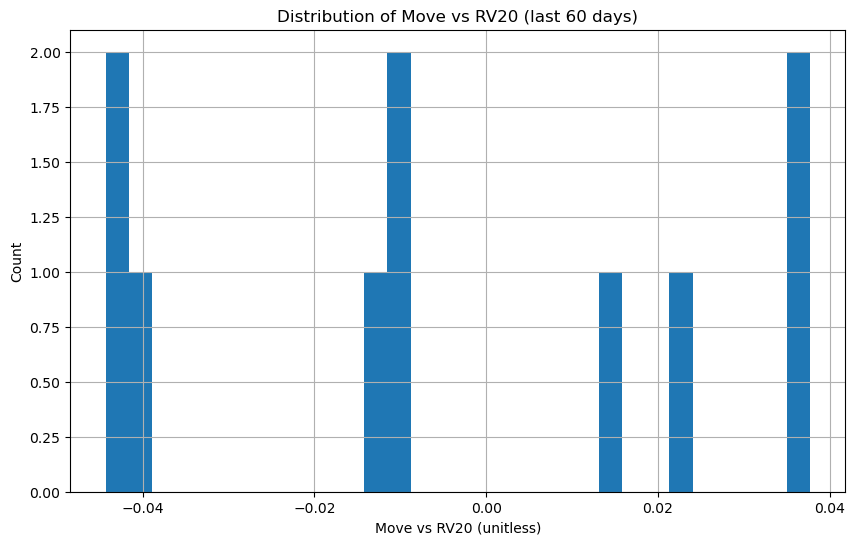

Right now the distribution is thin because we only have a small sample.
As more days accumulate, we expect most values to cluster near 0,
with outliers where today's move is unusually large relative to RV20.


In [8]:
## 7.1 Distribution of move_vs_rv20

clean_mv = features.replace([float("inf"), float("-inf")], np.nan)
clean_mv = clean_mv.dropna(subset=["move_vs_rv20"])

clean_mv["move_vs_rv20"].hist(bins=30)
plt.title(f"Distribution of Move vs RV20 (last {LOOKBACK_DAYS} days)")
plt.xlabel("Move vs RV20 (unitless)")
plt.ylabel("Count")
plt.show()

print("Right now the distribution is thin because we only have a small sample.")
print("As more days accumulate, we expect most values to cluster near 0,")
print("with outliers where today's move is unusually large relative to RV20.")

In [9]:
## 7.2 Vol regime vs edge bucket counts

pivot = con.sql("""
    SELECT
        vol_regime,
        edge_bucket,
        COUNT(*) AS cnt
    FROM screener_features
    GROUP BY vol_regime, edge_bucket
    ORDER BY vol_regime, edge_bucket
""").df()

pivot

,vol_regime,edge_bucket,cnt
0,high,hot,4
1,low,quiet,2
2,low,active,2
3,normal,active,2


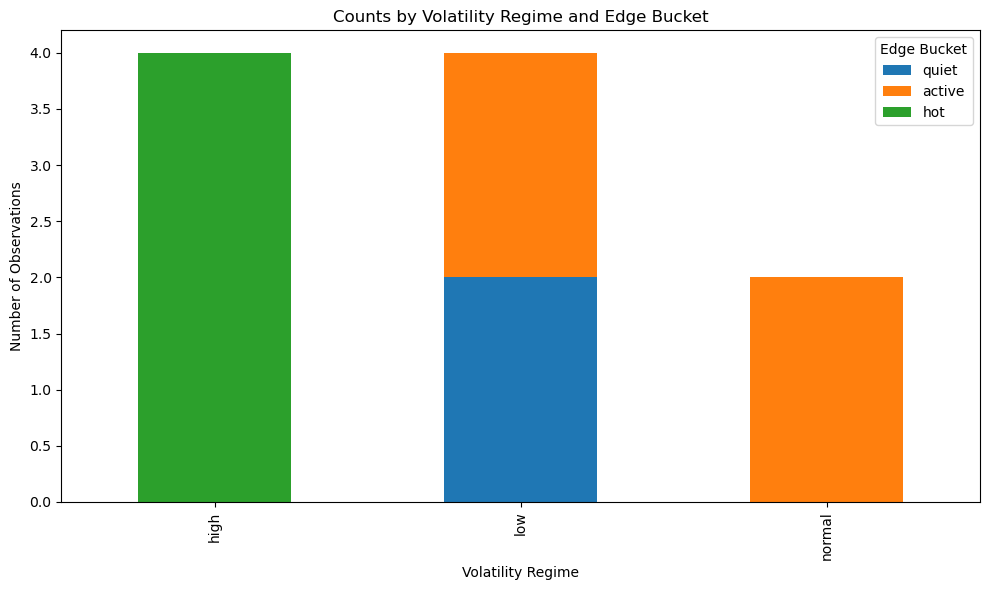

In [10]:
# Plot as a stacked bar chart
if not pivot.empty:
    plot_df = pivot.pivot(index="vol_regime", columns="edge_bucket", values="cnt").fillna(0)

    plot_df.plot(kind="bar", stacked=True)
    plt.title("Counts by Volatility Regime and Edge Bucket")
    plt.xlabel("Volatility Regime")
    plt.ylabel("Number of Observations")
    plt.legend(title="Edge Bucket")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough rows yet to build a regime × edge bucket plot.")

**Reading this plot:**  
This chart shows how often different volatility regimes (`low`/`normal`/`high`)  
coincide with different edge buckets (`quiet`/`active`/`hot`).  
With more history, this will tell us whether high-volatility environments tend  
to produce more “hot” edge days and where most of our potential trades live.

## 7.3 Example: 5-day rolling behaviour for one ticker

Here we look at a single ticker to see how the rolling mean and volatility of Day % evolve.
With more data, this becomes a nice way to identify trending vs choppy periods.

In [11]:
# Pick a ticker with the most history in this window
ticker_counts = features["ticker"].value_counts()
if not ticker_counts.empty:
    sample_ticker = ticker_counts.index[0]
    print(f"Sample ticker for rolling view: {sample_ticker}")

    example = (
        features[features["ticker"] == sample_ticker]
        .sort_values("run_date")
        [["run_date", "day_pct", "day_pct_ma_5", "day_pct_vol_5"]]
        .copy()
    )

    display(example.head())

    if len(example) >= 3:
        fig, ax1 = plt.subplots()

        ax1.plot(example["run_date"], example["day_pct_ma_5"],
                 label="5d rolling mean of Day %", marker="o")
        ax1.set_ylabel("5d rolling mean Day %")
        ax1.set_xlabel("Run date")

        ax2 = ax1.twinx()
        ax2.plot(example["run_date"], example["day_pct_vol_5"], # type: ignore
                 label="5d rolling vol of Day %", color="orange", marker="x")
        ax2.set_ylabel("5d rolling vol of Day %")

        plt.title(f"{sample_ticker}: 5d Behaviour of Day %")
        fig.tight_layout()
        plt.show()

        print(
            "The 5-day rolling mean of Day % captures short-term trend, while the",
            "5-day rolling volatility captures choppiness.\n",
            "In a richer dataset, rising mean with falling volatility would point",
            "to cleaner trends; rising vol with flat mean would suggest noisy conditions.",
        )
    else:
        print("Not enough history yet to plot a meaningful rolling window.")
else:
    print("No tickers found in the features table.")


Sample ticker for rolling view: AMD


,run_date,day_pct,day_pct_ma_5,day_pct_vol_5
0,2025-11-30,1.535658,NaN,NaN
1,2025-12-01,-0.859649,0.338004,1.693738


Not enough history yet to plot a meaningful rolling window.


## 8. How these features feed RL & backtesting

Now that we have `screener_features`, we effectively have a **feature store**
for each (run_date, ticker) pair.

Key engineered fields:

- `move_vs_rv20` tells us how big today's move is relative to recent realized vol.
- `rv_trend` captures whether volatility is picking up or calming down.
- `day_pct_ma_5` and `day_pct_vol_5` describe short-term trend and choppiness.
- `vol_regime`, `edge_bucket`, and `liquidity_bucket` provide clean filters.

These can be used to:

1. **Backtest simple rules**, e.g.

   - only trade tickers in **high vol** regime with **hot** edge bucket  
   - size down in **thin** liquidity bucket

2. **Define the RL state space**, e.g.

   \> `state = [move_vs_rv20, rv_trend, day_pct_ma_5, day_pct_vol_5, one-hot(vol_regime), one-hot(edge_bucket)]`

---

### Skills shown

This notebook shows:

- SQL over DuckDB used as a lightweight feature store.
- Practical feature engineering for a live trading screener.
- Clear, interpretable regime and bucket design.
- Charts + commentary that tie the features back to trading decisions and RL.

In production, these features would be computed on a schedule (e.g. daily after
market close) and stored in a warehouse for backtesting, RL training, and
real-time trading dashboards.


In [12]:
con.close()